# Statistical Downscaling of CanRCM4 Model Using 2.5 km HRDPS Data
## Data Preprocessing

In [1]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import statistics as stat

#for linear regression
import statsmodels.api as sm
from sklearn import linear_model

#for NN
from sklearn.neural_network import MLPRegressor

In [2]:
#load in data
RCM_eigvecs = pd.read_csv('P_RCM_eigvecs.csv',header=None).to_numpy()
RCM_fracvar = pd.read_csv('P_RCM_fracVar.csv',header=None)[0].to_numpy()
RCM_PCs = pd.read_csv('P_RCM_PCs.csv',header=None).to_numpy()
#RCM_time = pd.read_csv('RCM_dates.csv',header=None).to_numpy()
RCM_lat = pd.read_csv('RCM_lat.csv',header=None)[0].to_numpy()
RCM_lon = pd.read_csv('RCM_lon.csv',header=None)[0].to_numpy()

hrdps_eigvecs = pd.read_csv('P_hrdps_eigvecs.csv',header=None).to_numpy()
hrdps_fracvar = pd.read_csv('P_hrdps_fracVar.csv',header=None)[0].to_numpy()
hrdps_PCs = pd.read_csv('P_hrdps_PCs.csv',header=None).to_numpy()
#hrdps_time = pd.read_csv('hrdps_dates.csv',header=None).to_numpy()
hrdps_lat = pd.read_csv('hrdps_lat.csv',header=None)[0].to_numpy()
hrdps_lon = pd.read_csv('hrdps_lon.csv',header=None)[0].to_numpy()

In [3]:
#generate dates
time2014 = pd.date_range(start=datetime.datetime(2014,1,1),end=datetime.datetime(2020,12,31))
time2015 = pd.date_range(start=datetime.datetime(2015,1,1),end=datetime.datetime(2020,12,31))

#drop leap days
time2014 = np.delete(time2014,[list(time2014).index(datetime.datetime(2016,2,29)),list(time2014).index(datetime.datetime(2020,2,29))])
time2015 = np.delete(time2015,[list(time2015).index(datetime.datetime(2016,2,29)),list(time2015).index(datetime.datetime(2020,2,29))])

In [4]:
# #find index of extra day (leap day)
# ind = list(hrdps.time_counter.values).index(np.datetime64('2016-02-29T00:00:00.000000000'))

## PCA 
First with CanRCM4 Model outputs

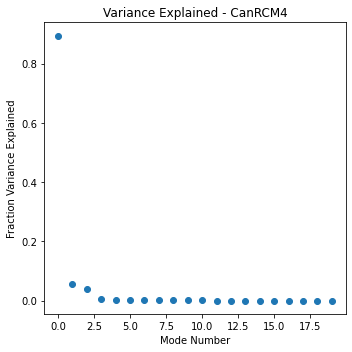

In [5]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(RCM_fracvar[0:20])),RCM_fracvar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained - CanRCM4')

plt.tight_layout()

plt.show()

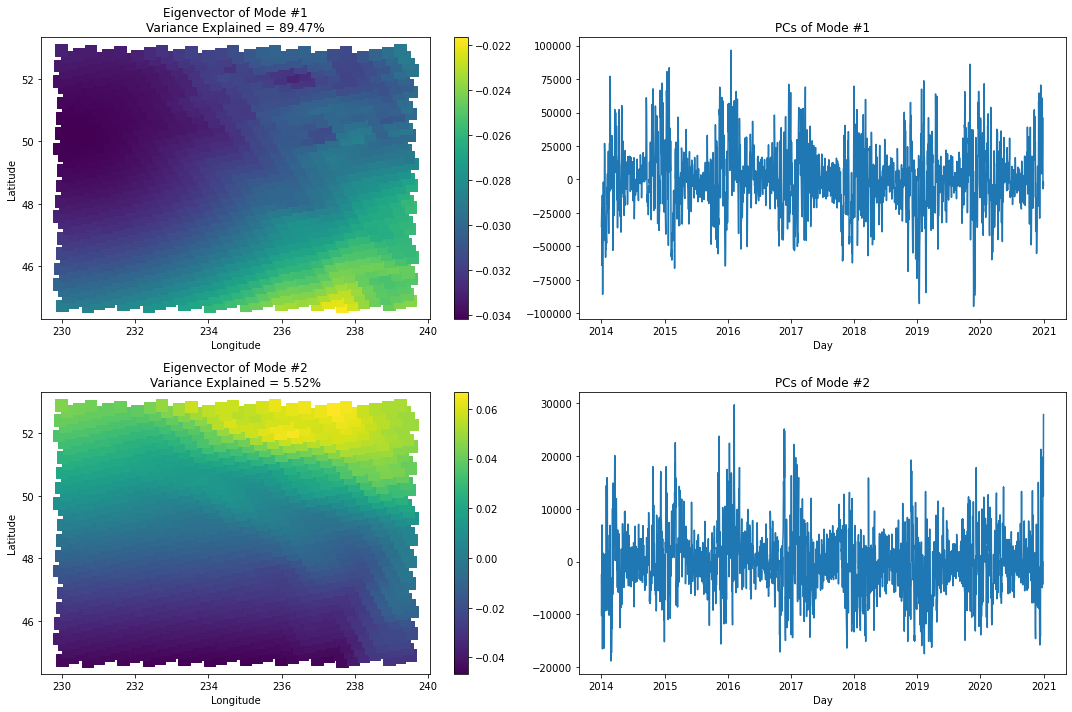

In [6]:
#keep first two modes
#visualise P component
n = 2
# day1 = 1
# dayfinal = len(RCM_time)

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(RCM_lon, RCM_lat,
            c = RCM_eigvecs[kk,:],
            cmap = 'viridis',
            s = 133,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round((RCM_fracvar[kk]*100),2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    #plt.plot(range(day1,dayfinal+1),RCM_PCs[:,kk])
    plt.plot(time2014,RCM_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()
    
#plt.savefig('PCA-RCM-P.png')

Now on the HRDPS Data

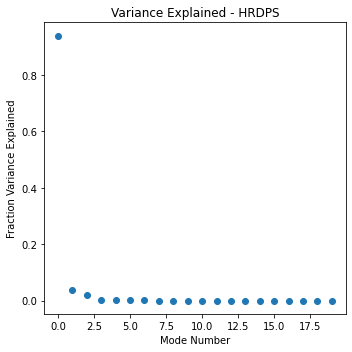

In [7]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(hrdps_fracvar[0:20])),hrdps_fracvar[0:20]) #plot only first 20
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained - HRDPS')

plt.tight_layout()

plt.show()

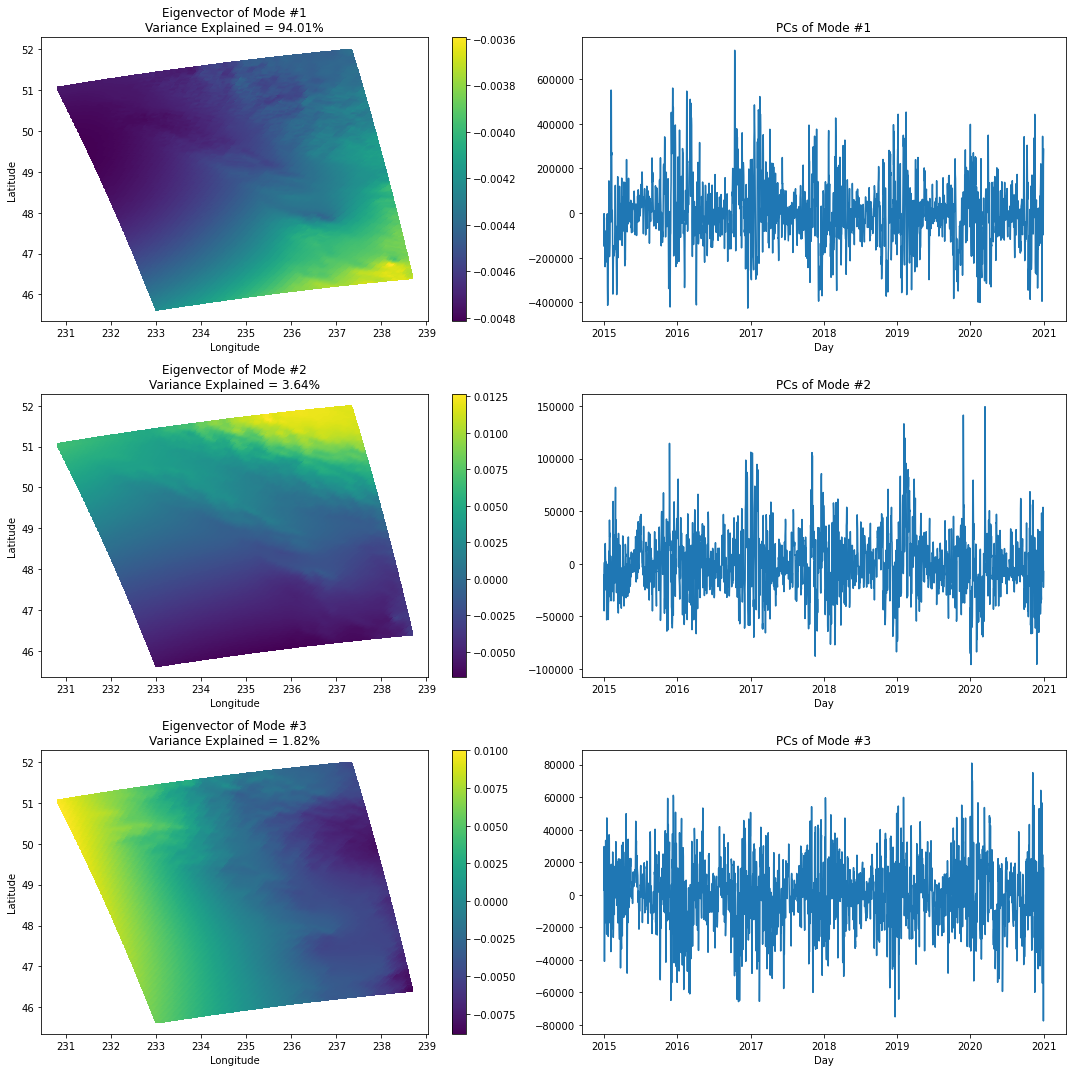

In [8]:
#keep first mode
#visualise
n = 3
# day1 = 1
# dayfinal = len(hrdps_time)

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = hrdps_eigvecs[kk,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round((hrdps_fracvar[kk]*100),2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
#     plt.plot(range(day1,dayfinal+1),hrdps_PCs[:,kk])
    plt.plot(time2015,hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

#plt.savefig('PCA-HRDPS-U.png')

## Normalization
Normalisation done between 0 and 1<br>
data max and min saved so that PCs can be reverted back to<br>
only looking at mode 1

In [9]:
RCM_norm = RCM_PCs[:,:2] #CanRCM4 PCAs as x, also trimmed to same time extent as hrdps in this step
hrdps_norm = hrdps_PCs[:,:1] #HRDPS PCAs as y

#normalise them first
xmax = np.max(RCM_norm,axis=0)
xmin = np.min(RCM_norm,axis=0)
ymax = np.max(hrdps_norm,axis=0)
ymin = np.min(hrdps_norm,axis=0)

RCM_norm-=xmin
RCM_norm/=(xmax-xmin)
hrdps_norm-=ymin
hrdps_norm/=(ymax-ymin)

## Linear Regression

In [10]:
x = pd.DataFrame(RCM_norm[365:,0])
y = pd.DataFrame(hrdps_norm)

In [11]:
#apply MLR on X and Y

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(x,y)
ypred_MLR = lm_MLR.predict(x) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(x,y) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
# print('a2 = ' + str(coef_MLR[1]))
# print('a3 = ' + str(coef_MLR[2]))
# print('a4 = ' + str(coef_MLR[3]))
print("R^2 =" + str(R2_MLR))

MLR results:
a0 = [0.35753604]
a1 = [0.02227502]
R^2 =0.00047947687672678097


Text(0.5, 1.0, 'MLR 1 predictor - SLP\n R^2 = 0.00047947687672678097')

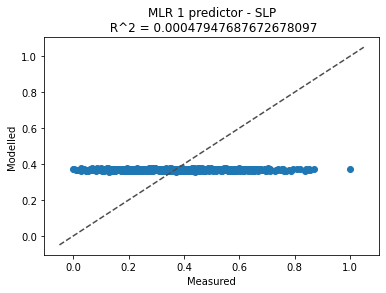

In [12]:
#plot MLR results alone

ax1 = plt.subplot(111)
ax1.scatter(y,ypred_MLR)
l1 = np.min(ax1.get_xlim())
l2 = np.max(ax1.get_xlim())
ax1.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured')
plt.ylabel('Modelled')
plt.title('MLR 1 predictor - SLP\n R^2 = ' + str(R2_MLR))


These results are similar to what we see when applying MLP NN - reconstruction very bad at modelling 'extreme' values.

In [13]:
x = pd.DataFrame(RCM_norm[365:,:])
y = pd.DataFrame(hrdps_norm)

In [14]:
#apply MLR on X and Y

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(x,y)
ypred_MLR = lm_MLR.predict(x) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(x,y) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
# print('a2 = ' + str(coef_MLR[1]))
# print('a3 = ' + str(coef_MLR[2]))
# print('a4 = ' + str(coef_MLR[3]))
print("R^2 =" + str(R2_MLR))

MLR results:
a0 = [0.37689656]
a1 = [ 0.02116411 -0.04836793]
R^2 =0.0026590395383998544


Text(0.5, 1.0, 'MLR 2 predictors - SLP\n R^2 = 0.0026590395383998544')

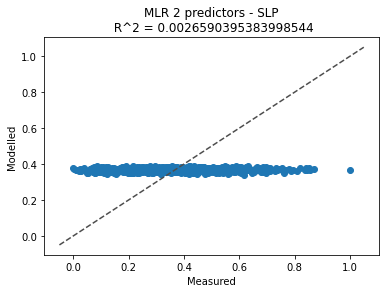

In [15]:
#plot MLR results alone

ax1 = plt.subplot(111)
ax1.scatter(y,ypred_MLR)
l1 = np.min(ax1.get_xlim())
l2 = np.max(ax1.get_xlim())
ax1.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured')
plt.ylabel('Modelled')
plt.title('MLR 2 predictors - SLP\n R^2 = ' + str(R2_MLR))

The really tiny difference in apperance between the two plots reiterates that only one predictor is necessary

## Correlation Analysis

OKKKKKKK lets see how well dominant PCs of both datasets corelate with eachother in time - maybe this way we can see if lagging helps <br>

Don't think CCA is the right choice for this analysis, just calc R^2 values between PCs of same mode 

In [16]:
x = RCM_norm[365:,0] #CanRCM4 PCs as x
y = hrdps_norm[:,0] #HRDPS PCs as y

#calc r value
r = np.corrcoef(x,y)

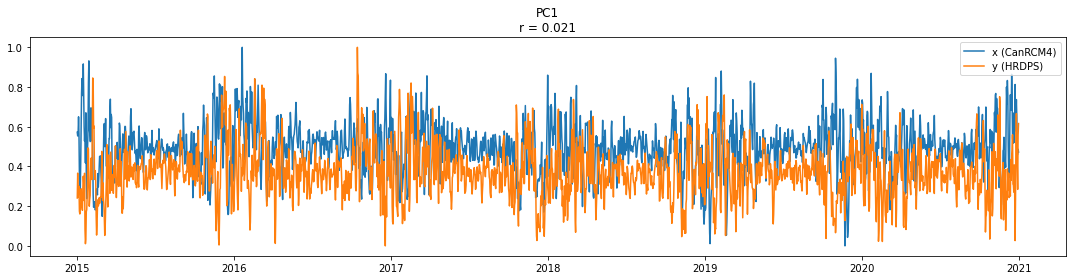

In [17]:
plt.figure(figsize=(15,4))

plt.plot(time2015,x)
plt.plot(time2015,y)
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC1\nr = ' + str(r[0][1])[:5])


plt.tight_layout()

Ok so we care the most about the PC1s being similar, so try lagging the CanRCM4 data so that r for this increases (potentially at the expence of PC2 and PC3 correlation). 

In [18]:
#do correlation on lagged dataset
#first shift CanRMC4 backwards (ex. June 3 of CanRCM4 aligns with June 1 of HRDPS)
r = []
PCx = x
PCy = y

for shift in range(100):
    shift += 1
    x = PCx[shift:].T #need to trim beginning of x by amount you want to shift
    y = PCy[:-shift].T #need to trim end of y by ammount CanRCM4 is shifted backwards

    r.append(np.corrcoef(x,y)[0][1])

print('Correlation after lagging by ' + str(r.index(max(r))+1) + ' day(s): r=' + str(max(r)))

# plt.plot(x[:,0])
# plt.plot(y[:,0])
# plt.legend(['x (CanRCM4)','y (HRDPS)'])
# plt.title('PC1\nr = ' + str(r[0][0,1])[:4])

Correlation after lagging by 29 day(s): r=0.12345343949151683


In [19]:
#do correlation on lagged dataset
#first shift CanRMC4 forwards (ex. June 1 of CanRCM4 aligns with June 3 of HRDPS)
r = []

for shift in range(100):
    shift += 1
    x = PCx[:-shift].T #need to trim end of x by ammount CanRCM4 is shifted
    y = PCy[shift:].T #need to trim beginning of y by amount you want to shift

    r.append(np.corrcoef(x,y)[0][1])

print('Correlation after lagging by ' + str(r.index(max(r))+1) + ' day(s): r=' + str(max(r)))

# plt.plot(x[:,0])
# plt.plot(y[:,0])
# plt.legend(['x (CanRCM4)','y (HRDPS)'])
# plt.title('PC1\nr = ' + str(r[0][0,1])[:4])

Correlation after lagging by 50 day(s): r=0.12100364859763789


In [20]:
#Lagging forward by 25 days yielded the best results
shift = 25

x = PCx[shift:] #need to trim beginning of x by amount you want to shift
y = PCy[:-shift] #need to trim end of y by ammount CanRCM4 is shifted backwards

#calc r value of all three modes
r = np.corrcoef(x,y)[0][1]

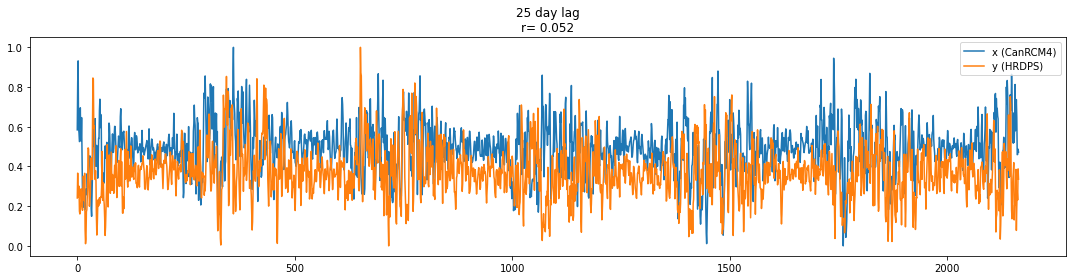

In [21]:
plt.figure(figsize=(15,4))

plt.plot(x)
plt.plot(y)
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('25 day lag\nr= '+str(r)[:5])


plt.tight_layout()

## Variance Analysis
looking at how the total variance in the winter months varies from year to year and between datasets

In [22]:
x = RCM_PCs[:,0] #CanRCM4 PCAs as x, also trimmed to same time extent as hrdps in this step
y = hrdps_PCs[:,0] #HRDPS PCAs as y

#normalise them first
xmax = np.max(x,axis=0)
xmin = np.min(x,axis=0)
ymax = np.max(y,axis=0)
ymin = np.min(y,axis=0)

x-=xmin
x/=(xmax-xmin)
y-=ymin
y/=(ymax-ymin)

In [23]:
# x = RCM_norm[:,0] #CanRCM4 PCs as x
# y = hrdps_norm[:,0] #HRDPS PCs as y

# #calc r value
# r = np.corrcoef(x,y)

In [24]:
#Select data first

x = x-stat.mean(x) #CanRCM4 PCs as x
y = y-stat.mean(y) #HRDPS PCs as y

In [25]:
#split datasets into different arrays for winters 2015/2016, 2016/2017, 2017/2018, 2018/2019, 2019/2020
#set 'winter' in Canada as October 1 - March 31

octo = 274 -1 #october 1 is the 274th day of the year (so ind 273)
mar = 365 + 90 - 1 #march 31 is the 90th day of the following year

WinterRCM = np.empty([6,(mar-octo)]) #one array for each dataset (each row for each year)
WinterHRDPS = np.empty([5,(mar-octo)])

for i in range(5): #5= num winter
    for j in range(mar-octo):
        #WinterRCM[i,j] = x[octo+(i*365)+j]
        WinterHRDPS[i,j] = y[octo+(i*365)+j]
        
for i in range(6): #5= num winter RCM
    for j in range(mar-octo):
        WinterRCM[i,j] = x[octo+(i*365)+j]

In [26]:
#get variance of each year
def var(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
    
varRCM = list(range(6))
varHRDPS = list(range(5))

for i in range(5):
    #varRCM[i]=var(WinterRCM[i,:])
    varHRDPS[i]=var(WinterHRDPS[i,:])
    
for i in range(6):
    varRCM[i]=var(WinterRCM[i,:])

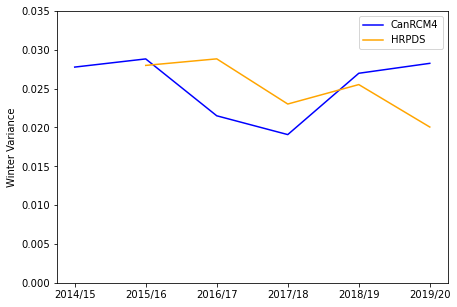

In [27]:
years= ['2015/16','2016/17','2017/18','2018/19','2019/20']
years_RCM = ['2014/15','2015/16','2016/17','2017/18','2018/19','2019/20',]

plt.figure(figsize=(7,5))


plt.plot(years_RCM, varRCM, label='CanRCM4',c='b')#,ls='--')
plt.plot(years, varHRDPS, label='HRPDS',c='orange')
plt.ylabel('Winter Variance')
plt.ylim(0,0.035)
#plt.xticks([0,1,2],['PC1','PC2','PC3'])
plt.legend()

## Winter versus summer variance

In [30]:
#split datasets into different arrays for winters and summers

octo = 274 -1 #october 1 is the 274th day of the year (so ind 273)
mar = 365 + 90 - 1 #march 31 is the 90th day of the following year

WinterRCM = [] #one array for each dataset (each row for each year)
SummerRCM = []
WinterHRDPS = []
SummerHRDPS = []

for i in range(5): #5= num winter
    for j in range(mar-octo):
        WinterHRDPS.append(y[octo+(i*365)+j])
    for k in range(365-(mar-octo)):
        SummerHRDPS.append(y[mar+(i*365)+k])        
        
for i in range(6): #5= num winter RCM
    for j in range(mar-octo):
        WinterRCM.append(x[octo+(i*365)+j])
    for k in range(365-(mar-octo)):
        SummerRCM.append(x[mar+(i*365)+k])

In [31]:
varRCM_winter = var(WinterRCM)
varRCM_summer = var(SummerRCM)
varHRDPS_summer = var(SummerHRDPS)
varHRDPS_winter = var(WinterHRDPS)

Text(0.5, 1.0, 'Seasonal variance over entire dataset')

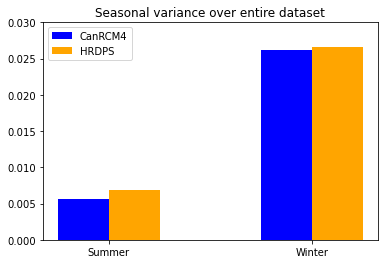

In [34]:
barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(2) #two points (summer and winter)
r2 = [x + barWidth for x in r1]


plt.bar(r1,[varRCM_summer,varRCM_winter],width=barWidth,label='CanRCM4',color='b')
plt.bar(r2,[varHRDPS_summer,varHRDPS_winter],width=barWidth,label='HRDPS',color='orange')
plt.ylim([0,0.03])
plt.xticks([r + barWidth/2 for r in range(2)], ['Summer','Winter'])
plt.legend()
plt.title('Seasonal variance over entire dataset')

## Histograms

Text(0.5, 1.0, 'Frequency distribution of normalised sea-level pressure')

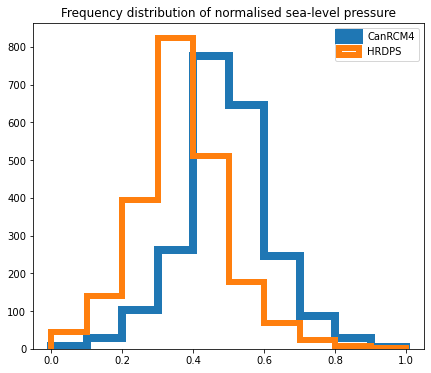

In [35]:
plt.figure(figsize=(7,6))

plt.hist(RCM_norm[:,0],bins=10,histtype='step',linewidth=8,label='CanRCM4')
plt.hist(hrdps_norm[:,0],bins=10,histtype='step',linewidth=6,label='HRDPS')
plt.legend()
plt.title('Frequency distribution of normalised sea-level pressure')

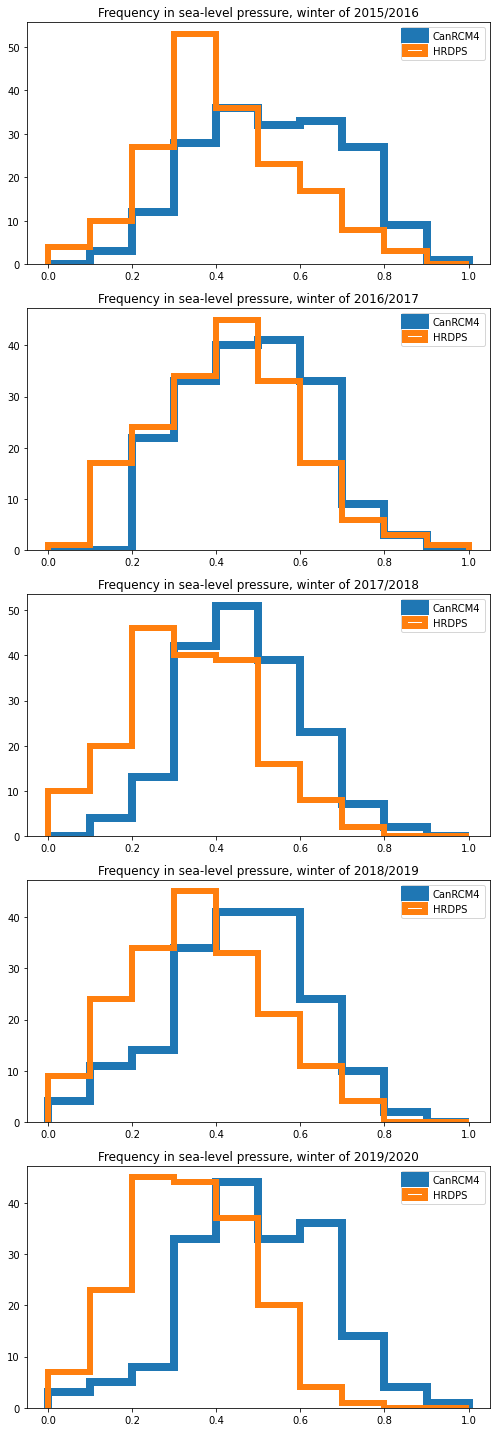

In [40]:
#look at it by winter
n = 5 #number of winters
b = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

plt.figure(figsize=(7,4*n))
for kk in range(n):
    
    plt.subplot(n,1,kk+1)
    plt.hist(WinterRCM[kk,:],bins=b,histtype='step',linewidth=8,label='CanRCM4')
    plt.hist(WinterHRDPS[kk,:],bins=b,histtype='step',linewidth=6,label='HRDPS')
    plt.legend()
    plt.title('Frequency in sea-level pressure, winter of 201'+str(5+kk)+'/20'+str(16+kk))
    
    plt.tight_layout()

## Count switches in pressure (high-low)

In [52]:
switch_RCM = np.zeros([1,6])[0]
switch_HRDPS = np.zeros([1,5])[0]

for i in range(5): #5 for 5 HRDPS winters
    for j in range(mar-octo-1):
        if (WinterHRDPS[i,j]-WinterHRDPS[i,j+1]>abs(0.3)):
            switch_HRDPS[i]+=1
            
for i in range(6): #6 for 6 CanRCM4 winters
    for j in range(mar-octo-1):
        if (WinterRCM[i,j]-WinterRCM[i,j+1]>abs(0.3)):
            switch_RCM[i]+=1

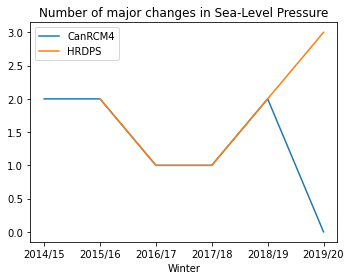

In [54]:
plt.figure(figsize=(5,4))
#x_axis=['2015/16','2016/17','2017/18','2018/19','2019/20']

plt.plot(years_RCM,switch_RCM,label='CanRCM4')
plt.plot(years,switch_HRDPS,label='HRDPS')
#plt.ylabel('Number of switches in wind direction per winter')
plt.xlabel('Winter')
plt.legend()
plt.title('Number of major changes in Sea-Level Pressure')

plt.tight_layout()

## Grid-search optimization

In [152]:
# #define RMSE as a function
# def rmse(target,prediction):
#     return(np.sqrt(((target - prediction)**2).sum()/len(target)))

Making a seperate NN for each HRDPS PC (use two at first and then analyse difference of just using 1)

In [153]:
# #set training and validation data - for 1st HRDPS PC
# #recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
# nPCs_RCM = 2
# nPCs_hrdps = 1

# x = RCM_PCs[shift:,:nPCs_RCM] #CanRCM4 PCAs as input
# y = np.squeeze(hrdps_PCs[:-shift,:nPCs_hrdps]) #HRDPS PCAs as output

# Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
# x_train = x[:Ntrain]
# y_train = y[:Ntrain]
# x_test = x[Ntrain:]
# y_test = y[Ntrain:]

# #unit based normalization wrt training set
# xmax = np.max(x_train,axis=0)
# xmin = np.min(x_train,axis=0)
# ymax = np.max(y_train,axis=0)
# ymin = np.min(y_train,axis=0)

# x_train-=xmin
# x_train/=(xmax-xmin)
# x_test-=xmin
# x_test/=(xmax-xmin)
# y_train-=ymin
# y_train/=(ymax-ymin)
# y_test-=ymin
# y_test/=(ymax-ymin)

In [154]:
# #This chunk of code is relatively flexible and can be used to loop through a range of parameters
# #We'll use this code several different times in the notebook
# #Play around and see what kinds of models you can make

# ##### Play around with these parameters
# num_models = 20 #number of models to build for the ensemble
# min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
# max_nhn = 243 #maximum number of hidden neurons to loop through
# max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
# batch_size = 32
# solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
# activation = 'relu'
# learning_rate_init = 0.01
# max_iter = 2000 #max number of epochs to run for any model
# early_stopping = True #True = stop early if validation error begins to rise
# validation_fraction = 0.2 #fraction of training data to use as validation
# #####

# y_out_all_nhn = []
# bestmodels = []
# y_out_ensemble = []
# RMSE_ensemble = [] #RMSE for each model in the ensemble
# RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
# nhn_best = []
# nhl_best = []

# for model_num in range(num_models): #for each model in the ensemble
    
#     print('Model Number: ' + str(model_num))
    
#     models = []
#     RMSE = []
#     y_out_all_nhn = []
#     nhn = []
#     nhl = []
    
#     for num_hidden_layers in range(1,max_hidden_layers+1):
    
#         #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
#         for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

#             #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
#             hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
#             model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
#                                  verbose=False,
#                                  max_iter=max_iter, 
#                                  early_stopping = early_stopping,
#                                  validation_fraction = validation_fraction,
#                                  batch_size = batch_size,
#                                  solver = solver,
#                                  activation = activation,
#                                  learning_rate_init = learning_rate_init)

#             model.fit(x_train,y_train) #train the model
#             models.append(model) #add the models to list to be accessed later

#             y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
#             y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
#             #now export the models from each run

#             RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
#             nhn.append(num_hidden_neurons)
#             nhl.append(num_hidden_layers)
        
#     indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
#     RMSE_ensemble.append(np.min(RMSE))
#     nhn_best.append(nhn[indBest])
#     nhl_best.append(nhl[indBest])
#     #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
#     y_out_ensemble.append(y_out_all_nhn[indBest])
#     bestmodels.append(models[indBest]) #only save the models that worked the best
    
#     print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
# y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
# RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 BEST: 2 hidden layers, 100 hidden neurons
Model Number: 1
	 BEST: 2 hidden layers, 117 hidden neurons
Model Number: 2
	 BEST: 2 hidden layers, 234 hidden neurons
Model Number: 3
	 BEST: 2 hidden layers, 176 hidden neurons
Model Number: 4
	 BEST: 2 hidden layers, 78 hidden neurons
Model Number: 5
	 BEST: 1 hidden layers, 151 hidden neurons
Model Number: 6
	 BEST: 1 hidden layers, 155 hidden neurons
Model Number: 7
	 BEST: 2 hidden layers, 207 hidden neurons
Model Number: 8
	 BEST: 1 hidden layers, 131 hidden neurons
Model Number: 9
	 BEST: 1 hidden layers, 184 hidden neurons
Model Number: 10
	 BEST: 1 hidden layers, 133 hidden neurons
Model Number: 11
	 BEST: 2 hidden layers, 62 hidden neurons
Model Number: 12
	 BEST: 1 hidden layers, 216 hidden neurons
Model Number: 13
	 BEST: 2 hidden layers, 182 hidden neurons
Model Number: 14
	 BEST: 2 hidden layers, 76 hidden neurons
Model Number: 15
	 BEST: 1 hidden layers, 82 hidden neurons
Model Number: 16
	 BEST: 1 hidden laye

In [155]:
# # therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
# PC1model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
# print(PC1model)

MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(117, 2),
             learning_rate_init=0.01, max_iter=2000, solver='sgd',
             validation_fraction=0.2)


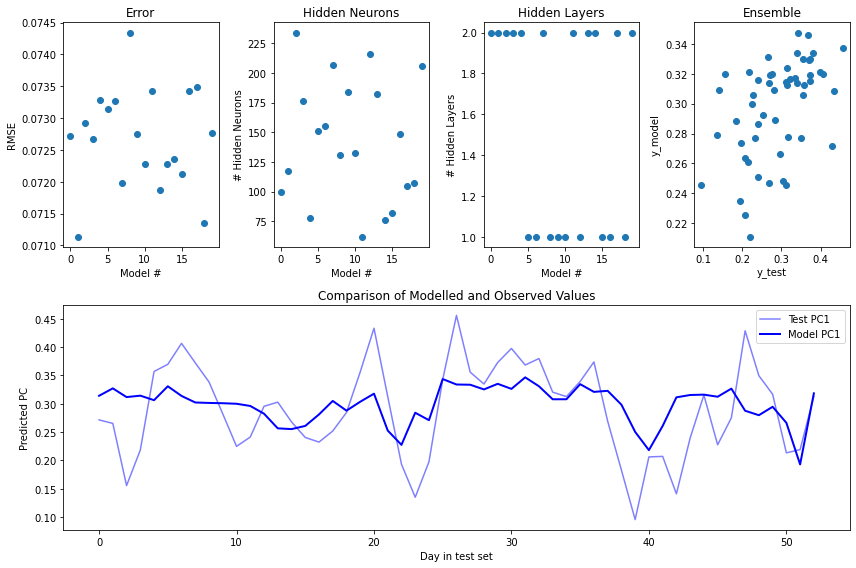

In [156]:
# #visualize

# plt.figure(figsize=(12,8))

# plt.subplot(241)
# #plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
# plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
# plt.xlabel('Model #')
# plt.ylabel('RMSE')
# plt.title('Error')

# plt.subplot(242)
# plt.scatter(range(len(nhn_best)),nhn_best)
# plt.xlabel('Model #')
# plt.ylabel('# Hidden Neurons')
# plt.title('Hidden Neurons')

# plt.subplot(243)
# plt.scatter(range(len(nhl_best)),nhl_best)
# plt.xlabel('Model #')
# plt.ylabel('# Hidden Layers')
# plt.title('Hidden Layers')

# plt.subplot(244)
# plt.scatter(y_test,y_out_ensemble_mean)
# #plt.plot((np.min(y_test),np.max(y_test)),'k--')
# plt.xlabel('y_test')
# plt.ylabel('y_model')
# plt.title('Ensemble')

# plt.subplot(212)
# plt.plot(y_test,alpha=0.5, label='Test PC1', c='b')
# # plt.plot(y_test[:,1],alpha=0.5, label='Test PC2', c='g')
# # plt.plot(y_test[:,2],alpha=0.5, label='Test PC3', c='r')
# plt.plot(PC1model.predict(x_test), label='Model PC1', c='b', lw=2)
# # plt.plot(PC1model.predict(x_test)[:,1], label='Model PC2', c='g', lw=2)
# # plt.plot(PC1model.predict(x_test)[:,2], label='Model PC3', c='r', lw=2)
# # plt.plot(y_out_ensemble_mean[:,0], label='Model PC1', c='b', lw=2)
# # plt.plot(y_out_ensemble_mean[:,1], label='Model PC2', c='g', lw=2)
# # plt.plot(y_out_ensemble_mean[:,2], label='Model PC3', c='r', lw=2)
# plt.legend()
# plt.xlabel('Day in test set')
# plt.ylabel('Predicted PC')
# plt.title('Comparison of Modelled and Observed Values')

# plt.tight_layout()

In [157]:
# #set training and validation data - for 2nd HRDPS PC
# #recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
# #NOTE: we only need to reset output (y)

# nPCs_hrdps = 2

# y = np.squeeze(hrdps_PCs[:,(nPCs_hrdps-1):nPCs_hrdps]) #HRDPS PCAs as output

# Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
# y_train = y[:Ntrain]
# y_test = y[Ntrain:]

# #unit based normalization wrt training set
# ymax = np.max(y_train,axis=0)
# ymin = np.min(y_train,axis=0)

# y_train-=ymin
# y_train/=(ymax-ymin)
# y_test-=ymin
# y_test/=(ymax-ymin)

In [185]:
# #This chunk of code is relatively flexible and can be used to loop through a range of parameters
# #We'll use this code several different times in the notebook
# #Play around and see what kinds of models you can make

# ##### Play around with these parameters
# num_models = 20 #number of models to build for the ensemble
# min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
# max_nhn = 243 #maximum number of hidden neurons to loop through
# max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
# batch_size = 32
# solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
# activation = 'relu'
# learning_rate_init = 0.01
# max_iter = 2000 #max number of epochs to run for any model
# early_stopping = True #True = stop early if validation error begins to rise
# validation_fraction = 0.2 #fraction of training data to use as validation
# #####

# y_out_all_nhn = []
# bestmodels = []
# y_out_ensemble = []
# RMSE_ensemble = [] #RMSE for each model in the ensemble
# RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
# nhn_best = []
# nhl_best = []

# for model_num in range(num_models): #for each model in the ensemble
    
#     print('Model Number: ' + str(model_num))
    
#     models = []
#     RMSE = []
#     y_out_all_nhn = []
#     nhn = []
#     nhl = []
    
#     for num_hidden_layers in range(1,max_hidden_layers+1):
    
#         #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
#         for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

#             #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
#             hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
#             model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
#                                  verbose=False,
#                                  max_iter=max_iter, 
#                                  early_stopping = early_stopping,
#                                  validation_fraction = validation_fraction,
#                                  batch_size = batch_size,
#                                  solver = solver,
#                                  activation = activation,
#                                  learning_rate_init = learning_rate_init)

#             model.fit(x_train,y_train) #train the model
#             models.append(model) #add the models to list to be accessed later

#             y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
#             y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
#             #now export the models from each run

#             RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
#             nhn.append(num_hidden_neurons)
#             nhl.append(num_hidden_layers)
        
#     indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
#     RMSE_ensemble.append(np.min(RMSE))
#     nhn_best.append(nhn[indBest])
#     nhl_best.append(nhl[indBest])
#     #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
#     y_out_ensemble.append(y_out_all_nhn[indBest])
#     bestmodels.append(models[indBest]) #only save the models that worked the best
    
#     print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
# y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
# RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

In [ ]:
# # therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
# PC2model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
# print(PC2model)

In [ ]:
# #visualize

# plt.figure(figsize=(12,8))

# plt.subplot(241)
# #plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
# plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
# plt.xlabel('Model #')
# plt.ylabel('RMSE')
# plt.title('Error')

# plt.subplot(242)
# plt.scatter(range(len(nhn_best)),nhn_best)
# plt.xlabel('Model #')
# plt.ylabel('# Hidden Neurons')
# plt.title('Hidden Neurons')

# plt.subplot(243)
# plt.scatter(range(len(nhl_best)),nhl_best)
# plt.xlabel('Model #')
# plt.ylabel('# Hidden Layers')
# plt.title('Hidden Layers')

# plt.subplot(244)
# plt.scatter(y_test,y_out_ensemble_mean)
# #plt.plot((np.min(y_test),np.max(y_test)),'k--')
# plt.xlabel('y_test')
# plt.ylabel('y_model')
# plt.title('Ensemble')

# plt.subplot(212)
# plt.plot(y_test,alpha=0.5, label='Test PC1', c='g')
# plt.plot(PC1model.predict(x_test), label='Model PC1', c='g', lw=2)
# plt.legend()
# plt.xlabel('Day in test set')
# plt.ylabel('Predicted PC')
# plt.title('Comparison of Modelled and Observed Values')

# plt.tight_layout()

In [ ]:
# plt.figure(figsize=(12,8))


# plt.subplot(311)
# plt.plot(y[:,0],alpha=0.2, label='PC1', c='b')
# plt.plot(model.predict(x)[:,0], label='Model PC1', c='b', lw=2)
# plt.legend()
# plt.ylabel('Predicted PC')
# plt.title('Comparison of Modelled and Observed Values')

# plt.subplot(312)
# plt.plot(y[:,1],alpha=0.2, label='PC2', c='g')
# plt.plot(model.predict(x)[:,1], label='Model PC2', c='g', lw=2)
# plt.legend()
# plt.ylabel('Predicted PC')

# plt.subplot(313)
# plt.plot(y[:,2],alpha=0.2, label='PC3', c='r')
# plt.plot(model.predict(x)[:,2], label='Model PC3', c='r', lw=2)
# plt.legend()
# plt.xlabel('Day in test set')
# plt.ylabel('Predicted PC')

## Future prediction and reconstruction

In [79]:
#reconstruct - with model PCs

PCs = model.predict(x)
#PCs = PCs*(xmax-xmin)+xmin


numObs = np.shape(hrdps_eigvecs)[0]-1
data_rec = np.empty([numObs,np.shape(hrdps_eigvecs)[1]])
for kk in range(numObs): #for each time step
    this_rec = np.zeros([1,np.shape(hrdps_eigvecs)[1]])
    for mode in range(3): #range is number of modes we kept
        this_rec += hrdps_eigvecs[mode,:]*PCs[kk,mode]    
    data_rec[kk,:] = this_rec

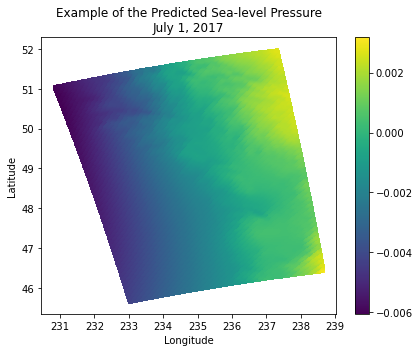

In [80]:
#visualize reconstruction - with model PCs
plt.figure(figsize=(6,5))

plt.scatter(hrdps_lon, hrdps_lat,
            c = data_rec[547,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
plt.title('Example of the Predicted Sea-level Pressure\nJuly 1, 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.tight_layout()

In [75]:
#reconstruct - with actual PCs

numObs = np.shape(hrdps_eigvecs)[0]-1
data_rec = np.empty([numObs,np.shape(hrdps_eigvecs)[1]])
for kk in range(numObs): #for each time step
    this_rec = np.zeros([1,np.shape(hrdps_eigvecs)[1]])
    for mode in range(3): #range is number of modes we kept
        this_rec += hrdps_eigvecs[mode,:]*hrdps_PCs[kk,mode]    
    data_rec[kk,:] = this_rec

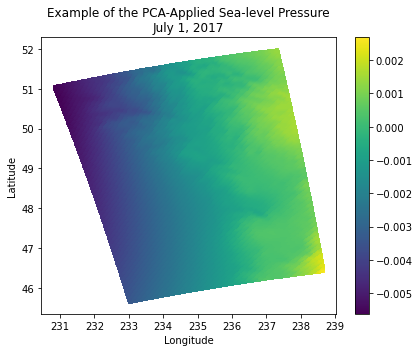

In [76]:
#visualize reconstruction - with actual PCs
plt.figure(figsize=(6,5))

plt.scatter(hrdps_lon, hrdps_lat,
            c = data_rec[547,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
plt.title('Example of the PCA-Applied Sea-level Pressure\nJuly 1, 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.tight_layout()